In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

# Table of Contents:
* [Part1.](#part1) EDA and Feature Engineering
    - [Explore the Target Variable](#target)
    - [Categorical Features](#cat_features)
        - [Step 1](#task1)
        - [Step 2](#task2)
        - [Step 3](#task3)
        - [Step 4](#task4)
        - [Step 5](#task5)
    - [Ordinal and numeric features](#rest_features)
        - [Step 6](#task6)
        - [Step 7](#task7)
        - [Step 8](#task8)
        - [Step 9](#task9)
    - [Missing values](#na)
        - [Step 10](#task10)
        - [Step 11](#task11)
    - [Columns transformers](#columns)
        - [Step 12](#task12)
    - [Train-test split](#train_test)
* [Part2](#part2). Training, comparing and testing models
    - [Step 13](#task13)
    - [Step 14](#task14)
    - [Step 15](#task15)

# Part 1. Exploratory Data Analysis (EDA) and Feature Engineering <a class="anchor" id="part1"></a>


### The goal
Explore the data, fix NAs, check if there are some mistakes and outliers, preprocess and select relevant features before fitting the model.


## Explore the dataset and the task

Below you can find the dataset, which you will be working with in this assignment. It contains information about the passangers of the Titanic. The target variable that we are going to predict is `Survived`. It is a binary variable which indicates whether a given passenger survived in the Titanic catastroph.

In [2]:
titanic = pd.read_csv('https://github.com/mbburova/MDS/raw/main/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have data for Titanic passengers, the goal is to predict the column `Survived`.

## Explore the target

To begin with, let me plot the barplot for the traget variable. It is very convenient to use wrapper around `matplotlib` provided by `pandas`. You can read about it [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html#cookbook-plotting).

0    549
1    342
Name: Survived, dtype: int64


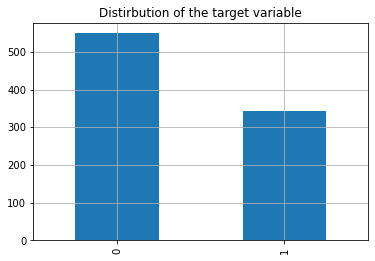

In [4]:
print(titanic.Survived.value_counts())
titanic.Survived.value_counts().plot(kind='bar')
plt.grid()
plt.title('Distirbution of the target variable');

---
## 1.1 Explore categorical features


We will start from creating a new feature called `Title`. By the title I mean the name prefix, such as `Mr`, `Miss`, `Dr` etc. It may tell us a lot about age or family status of the passenger even if this information is missing from the dataset. 

Let us take a look at some of the `Name` values. You can see that for each passenger name is organised as: 

```
Surname, Title. Name
```

In [5]:
titanic.Name[:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

---
**<ins>Step 1:</ins>** Add a new column `Title` to the `titanic` dataframe.

*Hints:* 
1. We need to extract part of the string from each value of the `Name` column
2. `pandas.Series.str` has wide variaty of vectorized string functions. That is, if you run `titanic.Name.str.useful_function()`, then `useful_function()` will be applied to each element of the column `Name`. Take a look at the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.html) for more details and the list of "useful functions".
3. We'll likelily need to apply regular expressions (but it is also to possible to do the task without it). Do not worry, it is nothing sophisticated. Here is all we need to know:
 * `[a-zA-Z]` - refers to any letter 
 * `\.` - refers to the dot
 * `\,` - refers to the comma
 * `+` - means that the element repeats 1 or more times. E.g. `\.+` means 1 or more dots
 * `\s` - refers to any spacing sign 
4. Extract the title without the dot that goes after it

In [6]:
import re
titanic['Title'] = titanic['Name'].apply(lambda x: re.compile("[A-Z][a-z]+\.").findall(x)[0][:-1])

In [7]:
titanic.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Jonkheer      1
Mme           1
Sir           1
Don           1
Lady          1
Capt          1
Ms            1
Name: Title, dtype: int64

We can see that some titles are very rare, which makes their usefulness questionable. I will now combine all the titles which has 6 or less observations into one category called `Other`.

---
**<ins>Step 2:</ins>** Let's create a vector `proper_titles` which contains all titles with > 6 observations. For all the passengers, who have title not from the `proper_titles` list, rename their `Title` to `Other`.

In [8]:
proper_titles = titanic['Title'].value_counts(dropna=False)
proper_titles = list(proper_titles[proper_titles > 6].index)
proper_titles

['Mr', 'Miss', 'Mrs', 'Master', 'Dr']

In [9]:
titanic['Title'] = titanic['Title'].apply(lambda x: x if x in proper_titles else "Other")

In [10]:
print(titanic.Title.value_counts(dropna=False))

Mr        517
Miss      182
Mrs       125
Master     40
Other      20
Dr          7
Name: Title, dtype: int64


---
**<ins>Step 3:</ins>** Let's obtain the list of all the categorical columns (columns with data type `object`). Name this list `categ_columns`.

In [11]:
categ_columns = titanic.columns[titanic.dtypes == "object"].tolist()
print("Number of categorical features =", len(categ_columns))
print(categ_columns)

Number of categorical features = 6
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title']


Let us explore these categorical features in more details. We will use method `describe` to obtain some statistics about them. 

In [12]:
titanic[categ_columns].describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked,Title
count,891,891,891,204,889,891
unique,891,2,681,147,3,6
top,"Carter, Master. William Thornton II",male,CA. 2343,B96 B98,S,Mr
freq,1,577,7,4,644,517


Sometimes, categorical columns contain too many unique values, which do not have a lot of information about the task we are solving. There are cases, when it is possible to extract some useful details from such variables (as we just did with the `Name`). But if you can't it might be better to drop such variable. 


---
**<ins>Step 4:</ins>** Remove all the categorical features, which have more than 100 unique values. 

P.S. Remove the corresponding columns from the dataframe `titanic` and unpdate list of categorical feature `categ_columns` to contain only categorical features that are left. 

In [13]:
columns_to_drop = [el for el in categ_columns if titanic[el].unique().size > 100]
categ_columns = [el for el in categ_columns if titanic[el].unique().size <= 100]

print(columns_to_drop)
print(categ_columns)

['Name', 'Ticket', 'Cabin']
['Sex', 'Embarked', 'Title']


In [14]:
titanic.drop(columns_to_drop, axis=1, inplace=True)

print("Number of categorical features =", len(categ_columns))

Number of categorical features = 3


Let's consider distribution of all the categorical features now

---
**<ins>Step 5:</ins>** For each categorical feature I'm going draw two bar plots side by side. On the first plot, height of the bar should depict number of passengers in each category, while on the second, height of the bar should depict propostion of survived passengers in the category. 

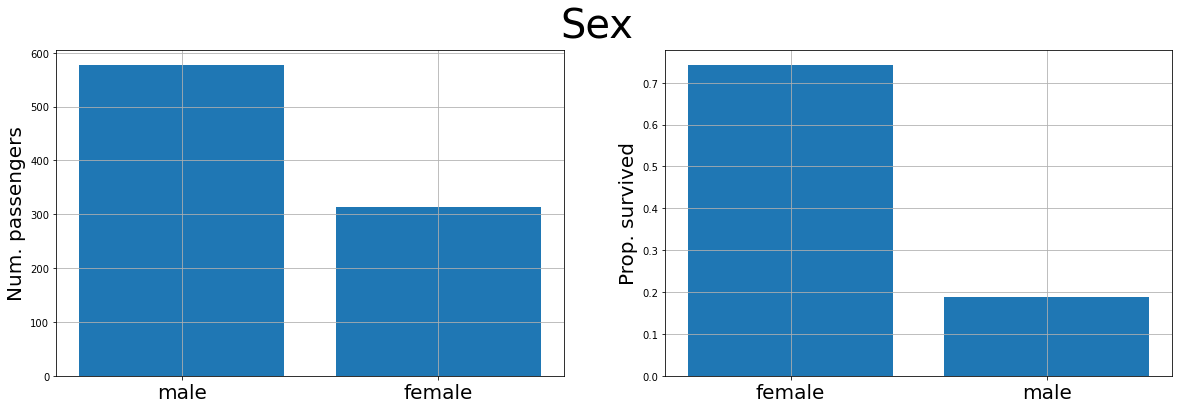

In [15]:
titanic.Sex.value_counts()
ratio_sex = titanic[titanic["Survived"] == 1]["Sex"].value_counts() / titanic["Sex"].value_counts(ascending=True)


fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
fig.suptitle("Sex", fontsize=40)

ax[0].bar(titanic['Sex'].value_counts(ascending=False).index, titanic['Sex'].value_counts())
ax[0].set_ylabel("Num. passengers", fontsize=20)
ax[0].tick_params(axis='x', labelsize=20)
ax[0].grid()

ax[1].bar(ratio_sex.index, ratio_sex);
ax[1].set_ylabel("Prop. survived", fontsize=20)
ax[1].tick_params(axis='x', labelsize=20)
ax[1].grid()

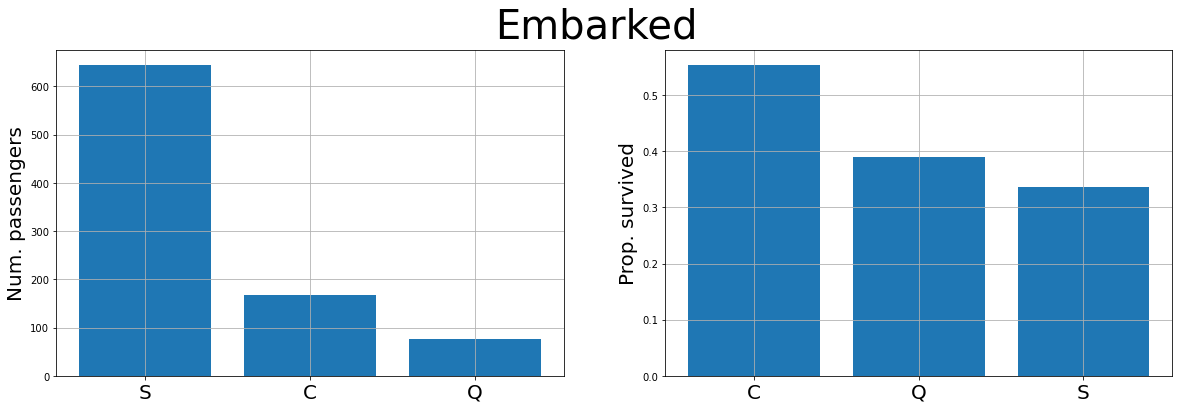

In [16]:
titanic.Embarked.value_counts()
ratio_embarked = titanic[titanic["Survived"] == 1]["Embarked"].value_counts() / titanic["Embarked"].value_counts()
ratio_embarked = ratio_embarked.sort_values(ascending=False)


fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
fig.suptitle("Embarked", fontsize=40)

ax[0].bar(titanic['Embarked'].value_counts().index, titanic['Embarked'].value_counts())
ax[0].set_ylabel("Num. passengers", fontsize=20)
ax[0].tick_params(axis='x', labelsize=20)
ax[0].grid()

ax[1].bar(ratio_embarked.index, ratio_embarked);
ax[1].set_ylabel("Prop. survived", fontsize=20)
ax[1].tick_params(axis='x', labelsize=20)
ax[1].grid()

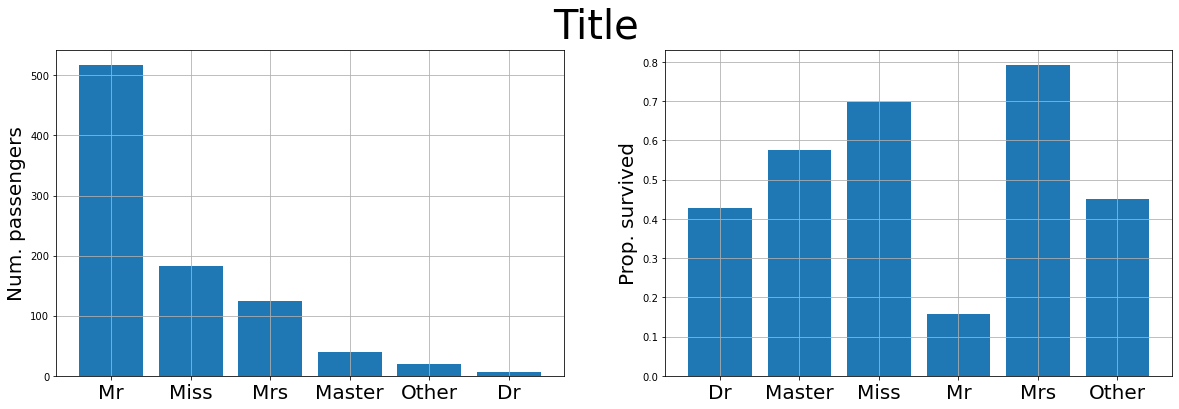

In [17]:
titanic.Title.value_counts()
ratio_title = titanic[titanic["Survived"] == 1]["Title"].value_counts() / titanic["Title"].value_counts()


fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
fig.suptitle("Title", fontsize=40)

ax[0].bar(titanic['Title'].value_counts().index, titanic['Title'].value_counts())
ax[0].set_ylabel("Num. passengers", fontsize=20)
ax[0].tick_params(axis='x', labelsize=20)
ax[0].grid()

ax[1].bar(ratio_title.index, ratio_title);
ax[1].set_ylabel("Prop. survived", fontsize=20)
ax[1].tick_params(axis='x', labelsize=20)
ax[1].grid()

---
## 1.2 Ordical and Numeric Features 

Now consider the rest of the dataset. Below you can see the first few observations from all the non-categorical features.

In [18]:
titanic[[c for c in titanic.columns if c not in categ_columns + ['Survived']]].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


---
**<ins>Step 6:</ins>** I would like to remove the feature `PassengerID` from the dataset since that doesn't have any informative value for prediction. 

In [19]:
titanic.drop(["PassengerId"], axis=1, inplace=True)
assert 'PassengerId' not in titanic.columns
titanic.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs


---
Let's consider two columns: `SibSp` and `Parch`. The first one is responsible for number of Siblings/Spouses aboard the Titanic for the given passenger. The second one - number of parents/childer aboard the Titanic. Note that we can create one variable `FamilySize` out of these two. 

**<ins>Step 7:</ins>** Create a variable `FamilySize` as a total size of the passenger's family aboard. Remove columns `SibSp` and `Parch` from the dataset afterwards. 

In [20]:
titanic['FamilySize'] = titanic.SibSp + titanic.Parch
titanic.drop(['SibSp', 'Parch'], axis=1, inplace=True)

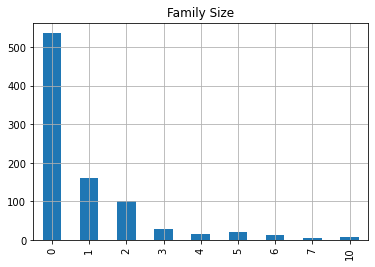

In [21]:
titanic.FamilySize.value_counts().sort_index().plot(kind='bar')
plt.title('Family Size')
plt.grid()

---
Let us work with the variable `FamilySize` even further. Turns out, that sometimes it is reasonable to convert numerical feature into ordinal ones. E.g. instead of having a family size we can group peopple into `single`, `small_family`, etc. In this manner we can enforce larger distinction between people who do not have family at all and those who have small families. At the same time we can say that for the sake of our application we do not need to distiguish family of size 1 from the family of size 2. 

**<ins>Step 8:</ins>** I'll plot the bar plot for the variable `FamilySize` where the height of the bar is determined by the proportion of the survived passengers. Based on the created plot I'll split all the passengers into tree groups. For each group binary variables `FamilySize_1`, `FamilySize_2` and `FamilySize_3` will be created. 

In [22]:
survived_prop = titanic['FamilySize'][titanic['Survived'] == 1].value_counts().sort_index() / titanic['FamilySize'].value_counts().sort_index()
survived_prop.fillna(0)

0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: FamilySize, dtype: float64

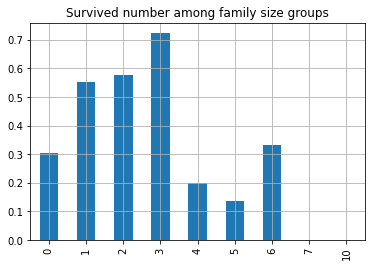

In [23]:
survived_prop.plot(kind='bar')
plt.title('Survived number among family size groups')
plt.grid()

In [24]:
def familySize(size):
    if 1 <= size <= 3:
        return "FamilySize_1"
    if size == 0 or 4 <= size <=6:
        return "FamilySize_2"
    return "FamilySize_3"

titanic["FamilySize"] = titanic['FamilySize'].apply(familySize)

In [25]:
titanic["FamilySize"].value_counts()

FamilySize_2    586
FamilySize_1    292
FamilySize_3     13
Name: FamilySize, dtype: int64

In [1]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(titanic['FamilySize'].values.reshape(-1, 1))
transformed = ohe.transform(titanic['FamilySize'].values.reshape(-1, 1)).toarray()
fmsize = pd.DataFrame(transformed, columns=["FamilySize1", "FamilySize2", "FamilySize3"]).astype(int)
fmsize

NameError: name 'titanic' is not defined

In [27]:
titanic = pd.concat([titanic, fmsize], axis=1)
titanic.drop(['FamilySize'], axis=1, inplace=True)
titanic

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize1,FamilySize2,FamilySize3
0,0,3,male,22.0,7.2500,S,Mr,1,0,0
1,1,1,female,38.0,71.2833,C,Mrs,1,0,0
2,1,3,female,26.0,7.9250,S,Miss,0,1,0
3,1,1,female,35.0,53.1000,S,Mrs,1,0,0
4,0,3,male,35.0,8.0500,S,Mr,0,1,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,Other,0,1,0
887,1,1,female,19.0,30.0000,S,Miss,0,1,0
888,0,3,female,NaN,23.4500,S,Miss,1,0,0
889,1,1,male,26.0,30.0000,C,Mr,0,1,0


---

Basically, we've just converted numerical feature `FamilySize` into categorical one with three categories. Moreover, we've simultaniously performed One-hot encoding of this categorical feature and obtained three binary variables. Also I droped the feature `FamilySize` as it is not needed anymore.

---
**<ins>Step 9:</ins>** We have three features left unexplored. They are `Pclass`, `Age` and `Fare`. The first one stands for the ticket class, second - for the age of the passenger and the third one gives us price of the ticket. 

Let's create `ordinal_cols`, which will be list of all the ordinal columns (put there names of relevant columns) and `numeric_cols` - list with the names of the numeric columns. If there is no ordinal or numeric colums, I'll make the corrisponding list empty.

In [28]:
ordinal_cols = ["Pclass"]
numeric_cols = ["Age", "Fare"]

print('Ordinal columns are: ', ordinal_cols)
print('Numeric columns are: ', numeric_cols)

Ordinal columns are:  ['Pclass']
Numeric columns are:  ['Age', 'Fare']


We can use different plots to explore numerical features. Below there are examples represented with the variable `Age`. One reason, why it is usefull to make such plots is that it may help to fill in missing values.


We can use histograms or boxplots to see how numerical features depends on the categorical one.
1. Age vs Target


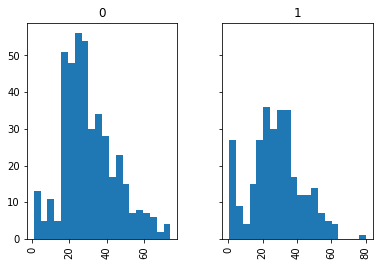


2. Age vs Sex


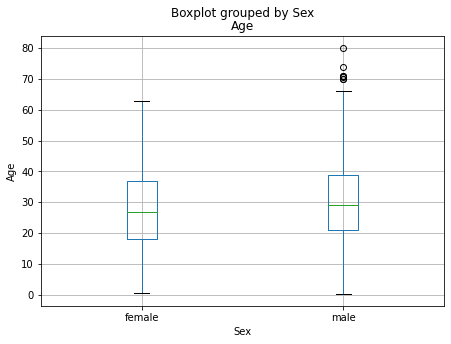

3. Age vs Target


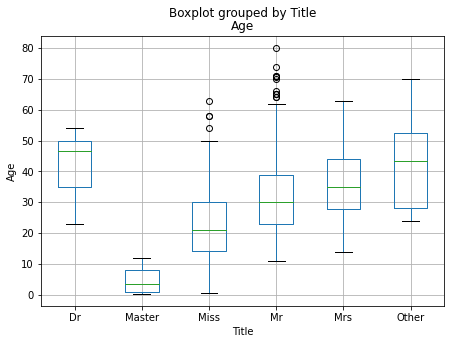


Scatter plots are usefull to spot connection between two numeric features.


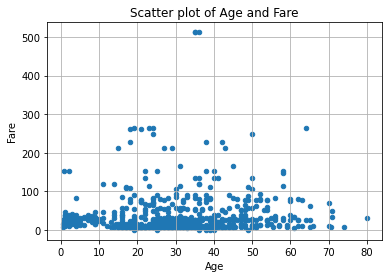

In [29]:
print()
print('We can use histograms or boxplots to see how numerical features depends on the categorical one.')
print('1. Age vs Target')
titanic.hist(column='Age', by='Survived', bins=20, sharey=True);
plt.show();

print()
print('2. Age vs Sex')
titanic.boxplot(column='Age', by='Sex', figsize=(7,5));
plt.ylabel('Age');
plt.show();

print('3. Age vs Target')
titanic.boxplot(column='Age', by='Title', figsize=(7,5));
plt.ylabel('Age');
plt.show();

print()
print('Scatter plots are usefull to spot connection between two numeric features.')
titanic.plot.scatter(x='Age', y='Fare');
plt.grid()
plt.title('Scatter plot of Age and Fare');

---
## 1.3 Working with missing values 
**<ins>Step 10:</ins>** Let's compute proportion of missing values in each column and store the answer in the variable `prop_missing`.


In [30]:
prop_missing = titanic.isna().sum() / titanic.shape[0]
prop_missing

Survived       0.000000
Pclass         0.000000
Sex            0.000000
Age            0.198653
Fare           0.000000
Embarked       0.002245
Title          0.000000
FamilySize1    0.000000
FamilySize2    0.000000
FamilySize3    0.000000
dtype: float64

We have two columns with missing values. 

In [31]:
titanic.columns[prop_missing > 0].values

array(['Age', 'Embarked'], dtype=object)

What can we do with that? Below we have some options listed:
- Fill all the NAs with the same value (mean, median, any other constant)
- Fill NAs using grouping (e.g. we can fill missing in the variable `Fare` for male and female passengers separately using their average value)
- Drop all the rows with missing values
- Drop the whole column (e.g. if there are too many missing values)

The most popular way is to use `SimpleImputer` from sklearn. If fills all the missing values with the same number. 


**<ins>Step 11:</ins>** I'm going to implement a more phisticated Imputer. `MeanGroupImputer`. We will make sure that it has proper sklearn interface, so that we can use it within our pipelines. 


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
class MeanGroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using mean value within group
    
    Parameters
    ----------    
    group_cols : str
        A column used to calculate the mean values
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_col):
        assert type(group_col) == str, 'group_col should be a string'

        self.group_col = group_col
    
    def fit(self, X, y=None):
        assert X[self.group_col].isna().sum() == 0, 'There are missing values in the group_col'
        
        # Group dataset by `group_col` and calculate mean value of all the other columns within this group
        self.mapping = X.groupby(self.group_col).mean()
        return self 
    
    def transform(self, X, y=None):
        X = X.copy()
        # make sure that the imputer was fitted
        assert self.mapping is not None
        
        # loop over all the groups
        for index, row in self.mapping.iterrows():

            # Fill in missing values for the group `index` with the values `row`            
            if index:
                X.loc[X[self.group_col] == index, row.index] \
                    = X.loc[X[self.group_col] == index, row.index].fillna(value=dict(zip(list(row.index), row.values)))

        # Then drop grouping column (we did not transform it, so it is not needed anymore)
        X.drop(self.group_col, axis=1, inplace=True)
        return X.values

In [33]:
# Test
toy_dataset = pd.DataFrame({'name': ['A','A', 'B','B','B','B', 'C','C','C'],
                            'value': [1, np.nan, 2, np.nan, 3, 1, 3, np.nan, 5],
                            'other_value': [10, np.nan, np.nan, 20, 30, 10, 30, np.nan, 30]})
print(toy_dataset)
imp = MeanGroupImputer(group_col='name')
output = imp.fit_transform(toy_dataset)
print(output)

# test that answers are correct for the toy dataset
assert (output[:, 0] == np.array([1.0, 1.0, 2.0, 2.0, 3.0, 1.0, 3.0, 4.0, 5.0])).all()
assert (output[:, 1] == np.array([10.0, 10.0, 20.0, 20.0, 30.0, 10.0, 30.0, 30.0, 30.0])).all()

  name  value  other_value
0    A    1.0         10.0
1    A    NaN          NaN
2    B    2.0          NaN
3    B    NaN         20.0
4    B    3.0         30.0
5    B    1.0         10.0
6    C    3.0         30.0
7    C    NaN          NaN
8    C    5.0         30.0
[[ 1. 10.]
 [ 1. 10.]
 [ 2. 20.]
 [ 2. 20.]
 [ 3. 30.]
 [ 1. 10.]
 [ 3. 30.]
 [ 4. 30.]
 [ 5. 30.]]


## 1.4 Define column transformers <a class="anchor" id="columns"></a>

 **<ins>Step 12:</ins>** In this task I'll define columns transformer and create three pipelines:
 - `age_pipe`: Pipeline to preprocess column `Age`. It uses `MeanGroupImputer` with the grouping variable `Title` to fill missing values in `Age` and then applies `StandardScaler`
 - `fare_pipe`: Pipeline to preprocess column `Fare`. It applies `StandardScaler` only
 - `categ_pipe`: Pipeline to preprocess all categorical variables. It uses `SimpleImputer` to impute missing values with the most frequent class and then applies `OneHotEncoder`


In [34]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

age_pipe = make_pipeline(MeanGroupImputer(group_col='Title'), StandardScaler())
fare_pipe = make_pipeline(StandardScaler())
categ_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())


# Combine all three pipelines in one column transformer
column_transformer = ColumnTransformer([
 ('age', age_pipe, ['Age', 'Title']),
 ('fare', fare_pipe, ['Fare']),
 ('all_categ', categ_pipe, categ_columns)],
remainder='passthrough'
)


In [35]:
titanic

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize1,FamilySize2,FamilySize3
0,0,3,male,22.0,7.2500,S,Mr,1,0,0
1,1,1,female,38.0,71.2833,C,Mrs,1,0,0
2,1,3,female,26.0,7.9250,S,Miss,0,1,0
3,1,1,female,35.0,53.1000,S,Mrs,1,0,0
4,0,3,male,35.0,8.0500,S,Mr,0,1,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,Other,0,1,0
887,1,1,female,19.0,30.0000,S,Miss,0,1,0
888,0,3,female,NaN,23.4500,S,Miss,1,0,0
889,1,1,male,26.0,30.0000,C,Mr,0,1,0


In [36]:
test_titanic = column_transformer.fit_transform(titanic)
print(pd.DataFrame(test_titanic))

           0         1    2    3    4    5    6    7    8    9    10   11  \
0   -0.584387 -0.502445  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
1    0.621365  0.786845  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2   -0.282949 -0.488854  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
3    0.395286  0.420730  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
4    0.395286 -0.486337  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
..        ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
886 -0.207590 -0.386671  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
887 -0.810466 -0.044381  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
888 -0.601421 -0.176263  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
889 -0.282949 -0.044381  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
890  0.169208 -0.492378  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   

      12   13   14   15   16   17  
0    0.0  0.0  3.0  1.0  0.0  0.0  
1  

## 1.5 Train/test split

In [37]:
from sklearn.model_selection import train_test_split

tr, te = train_test_split(titanic, test_size=0.2, random_state=42)

y_train = tr.Survived
y_test = te.Survived
X_train = tr.drop(['Survived'], axis=1)
X_test = te.drop(['Survived'], axis=1)

# Part 2. Logistic Regression and Support Vector Machine

## 2.1 Fit Logistic Regression


**<ins>Step 13:</ins>** I'm going to define the `log_reg_pipe` - pipeline which applies `column_transformer` and fits logistic regression with the the hyperparameter `penalty='none'` (by default sklearn applies L2 regularization). Then I'll calculate the 5-fold cross-validation score (using `accuracy` as a scoring function) and save the result (average accuracy on cross-validation) in the variable `log_reg_score`.

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


log_reg_pipe = Pipeline([
    ('preprocess', column_transformer),
    ('logReg', LogisticRegression(penalty='none', max_iter=1000))
])
log_reg_score = cross_val_score(log_reg_pipe, X_train, y_train, cv=5, scoring='accuracy').mean()
log_reg_score

0.7977149610952428

## 2.2 Fit Support Vector Machine

**<ins>Step 14:</ins>** I'm going to define the `svm_pipe` - pipeline which applies `column_transformer` and fits Support Vector Machine model using the hyperparameter `kernel='linear'`. Then I'll calculate the 5-fold cross-validation score (using `accuracy` as a scoring function) and save the result (average accuracy on cross-validation) in the variable `svm_score`.

In [39]:
from sklearn.svm import SVC


svm_pipe = Pipeline([
    ('preprocess', column_transformer),
    ('svm', SVC(kernel='linear'))
])
svm_score = cross_val_score(svm_pipe, X_train, y_train, cv=5, scoring='accuracy').mean()
svm_score

0.8047572146163695

## 2.3 Compare different models

**<ins>Step 15:</ins>** In this task I'm going to use grid search to find the best classifier for the given dataset. `GridSearchCV` class from sklearn and the case of 5-Fold cross validation with accuracy as a scoring metric will be used.

*Hints*. Read documentation to see, which hyperparameters `LogisticRegression` and `SVC` have. Pay attention to `kernel` in the SVM model and the regularization coefficient `C` for both LogisticRegression and SVC, try different penalties for `LogisticRegression`. Explore other hyperparameters as well. The minimum passing value for the step will be 0.84 (average score on cross-validaition).

In [40]:
from sklearn.model_selection import GridSearchCV

log_reg_pipe = Pipeline([
    ('preprocess', column_transformer),
    ('logReg', LogisticRegression(max_iter=1000))
])

param_grid = {
#     'logReg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logReg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logReg__C': np.linspace(0.1, 1, 10)
}
pipe_logGrid = GridSearchCV(log_reg_pipe, param_grid, cv=5, scoring='accuracy')
pipe_logGrid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('age',
                                                                         Pipeline(steps=[('meangroupimputer',
                                                                                          MeanGroupImputer(group_col='Title')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Title']),
                                                                        ('fare',
                                                            

In [41]:
pipe_logGrid.best_score_

0.8046981187826259

In [42]:
pipe_logGrid.best_estimator_.steps[1][1]

LogisticRegression(C=0.2, max_iter=1000, solver='newton-cg')

In [43]:
svm_pipe = Pipeline([
    ('preprocess', column_transformer),
    ('svm', SVC())
])

param_grid = {
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__C': np.linspace(0.1, 5, 50)
}

pipe_svmGrid = GridSearchCV(svm_pipe, param_grid, cv=5, scoring='accuracy')
pipe_svmGrid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('age',
                                                                         Pipeline(steps=[('meangroupimputer',
                                                                                          MeanGroupImputer(group_col='Title')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Title']),
                                                                        ('fare',
                                                            

In [44]:
pipe_svmGrid.best_score_

0.8356544863587116

In [45]:
pipe_svmGrid.best_estimator_.steps[1][1]

SVC(C=1.3000000000000003)

## 2.4 Eval best model on test

Now, we can use the best estimator to evaluate model on the test dataset. 

1. Fit model on the whole test data
2. Make predictions on the test set
3. Calculate accuracy

In [46]:
from sklearn.metrics import accuracy_score

pipe_svmGrid.best_estimator_.fit(X_train, y_train)
y_pred = pipe_svmGrid.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.8156424581005587